In [1]:
!pip install torch torchvision pandas numpy pillow scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set the path to your dataset on Google Drive
base_path = "/content/drive/MyDrive/final_dataset2"

# Verify the structure
!ls "{base_path}/train/"
# Should show _annotations.csv and image files

Mounted at /content/drive
_annotations.csv
_annotations_updated.csv
frame1000_jpg.rf.5ed5724c10ee1af5aa8a7f20baa910d6.jpg
frame1001_jpg.rf.4596efbc266b42f3365a6e18fbd402f8.jpg
frame1003_jpg.rf.30535d6d67bcf0442a43a0964e08ab3a.jpg
frame1004_jpg.rf.70e55ede84a57e7f7eca6151fd008502.jpg
frame1005_jpg.rf.b1311dfd2e2e637da5d50cbedcdfa463.jpg
frame1006_jpg.rf.2899adb94638e055b7474b01c2019ba5.jpg
frame1007_jpg.rf.1d57b6d47257109acd39d57aecf56338.jpg
frame1008_jpg.rf.ffda08fd836729398784c290c9823b26.jpg
frame1009_jpg.rf.83ad2a68a5d60b8e30dddc3df8ccc271.jpg
frame1010_jpg.rf.f1fa1a0799f5f4371b8eca21c4c788d0.jpg
frame1014_jpg.rf.4a862b5928e51392b30b1ab14bbe9222.jpg
frame1015_jpg.rf.3aeda83715808b0b992cd9a29c9cfed6.jpg
frame1016_jpg.rf.6c2e15bbf1d3568cc24b195ca0d4ca4e.jpg
frame1018_jpg.rf.6731793fb36244bef392f5882fe5e58b.jpg
frame1019_jpg.rf.1a6051004aff6428c7ee8a0a94e7cfbb.jpg
frame1020_jpg.rf.0b84ec1e860f00e1d06869e5545263a4.jpg
frame1022_jpg.rf.93d2b0136825e43e6cf1e38b16757cba.jpg
frame1024_jpg.

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import MultiScaleRoIAlign

# NonLocalSelfAttentionBlock
class NonLocalSelfAttentionBlock(nn.Module):
    def __init__(self, in_channels, num_heads=8):
        super().__init__()
        assert in_channels % num_heads == 0, "in_channels must be divisible by num_heads"
        self.attn = nn.MultiheadAttention(
            embed_dim=in_channels,
            num_heads=num_heads,
            batch_first=True
        )
        self.norm = nn.LayerNorm(in_channels)

    def forward(self, x):
        B, C, H, W = x.size()
        x_flat = x.view(B, C, -1).permute(0, 2, 1)  # [B, H*W, C]
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        attn_out = self.norm(attn_out + x_flat)  # Residual + norm
        x_out = attn_out.permute(0, 2, 1).view(B, C, H, W)
        return x + x_out  # Final residual

# Custom backbone with attention
class BackboneWithAttention(nn.Module):
    def __init__(self, backbone, return_layers, in_channels_attention=2048):
        super().__init__()
        self.body = nn.ModuleDict({
            name: module for name, module in backbone.named_children()
            if name != 'fc'
        })
        self.return_layers = return_layers
        self.attention = NonLocalSelfAttentionBlock(in_channels=in_channels_attention)
        self.out_channels = in_channels_attention

    def forward(self, x):
        features = {}
        for name, layer in self.body.items():
            x = layer(x)
            if name in self.return_layers:
                features[self.return_layers[name]] = x
        last_feature_key = max(features.keys())  # '3' for layer4
        features[last_feature_key] = self.attention(features[last_feature_key])
        return features

# Custom RPN head to handle multi-scale features
class CustomRPNHead(nn.Module):
    def __init__(self, in_channels_list, num_anchors):
        super().__init__()
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels, 256, kernel_size=1) for in_channels in in_channels_list
        ])
        self.rpn_head = RPNHead(256, num_anchors)

    def forward(self, features):
        # Process each feature map to 256 channels
        features_256 = [conv(f) for conv, f in zip(self.conv_layers, features)]
        return self.rpn_head(features_256)

# Function to create the model
def create_model(num_classes=3):  # Explicitly set to 3 classes (0=plain, 1=crater, 2=boulder)
    # Load pretrained ResNet50 backbone
    backbone = torchvision.models.resnet50(pretrained=True)
    return_layers = {'layer1': '0', 'layer2': '1', 'layer3': '2', 'layer4': '3'}

    # Wrap backbone with attention
    backbone_with_attention = BackboneWithAttention(
        backbone=backbone,
        return_layers=return_layers,
        in_channels_attention=2048
    )

    # Define anchor generator with sizes for each feature level
    anchor_generator = AnchorGenerator(
        sizes=((16, 32), (32, 64), (64, 128), (128, 256)),  # Adjusted sizes
        aspect_ratios=((0.5, 1.0, 2.0),) * 4
    )

    # Define custom RPN head with channel reduction
    in_channels_list = [256, 512, 1024, 2048]  # Channels from layer1, layer2, layer3, layer4
    rpn_head = CustomRPNHead(in_channels_list, anchor_generator.num_anchors_per_location()[0])

    # Define ROI pooling to use only layer4 (2048 channels)
    roi_pool = MultiScaleRoIAlign(
        featmap_names=['3'],  # Use only layer4
        output_size=7,
        sampling_ratio=2
    )

    # Create Faster R-CNN model
    model = FasterRCNN(
        backbone=backbone_with_attention,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        rpn_head=rpn_head,
        box_roi_pool=roi_pool,
    )

    # Customize the box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Add class weights (adjust based on your dataset)
    # Compute weights from training data (plain, crater, boulder)
    class_weights = torch.FloatTensor([1.0, 1.0, 1.0])  # Placeholder [plain, crater, boulder]
    # Example: If plain:400, crater:241, boulder:126, frequencies are 0.524, 0.316, 0.165
    # Weights = [1/0.524, 1/0.316, 1/0.165] ≈ [1.91, 3.16, 6.06]
    # Replace with your computed weights
    class_weights_tensor = class_weights  # Use the full class_weights tensor
    model.roi_heads.box_predictor.cls_score.weight.data = (
        model.roi_heads.box_predictor.cls_score.weight.data * class_weights_tensor.unsqueeze(1)
    )
    model.roi_heads.box_predictor.cls_score.bias.data.zero_()

    return model

In [4]:
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class LunarDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform
        self.imgs = list(self.annotations['filename'].unique())

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.imgs[idx])
        image = Image.open(img_name).convert("RGB")
        img_annotations = self.annotations[self.annotations['filename'] == self.imgs[idx]]

        boxes = []
        labels = []
        for _, row in img_annotations.iterrows():
            boxes.append([row['xmin'], row['ymin'], row['xmax'], row['ymax']])
            labels.append(1 if row['class'] == 'Crater' else 2)  # 1=Crater, 2=Boulder

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transform:
            image = self.transform(image)

        return image, target

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create datasets
train_dataset = LunarDataset(
    root_dir=f"{base_path}/train",
    csv_file=f"{base_path}/train/_annotations.csv",
    transform=transform
)

# Split into train and test (assuming you have enough data)
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [5]:
# Debug cell
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = create_model(num_classes=3).to(device)
images, targets = next(iter(train_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
model.train()
print("Backbone output shapes:")
backbone_output = model.backbone(images[0].unsqueeze(0))
for key, value in backbone_output.items():
    print(f"Layer {key}: {value.shape}")
with torch.no_grad():
    images_transformed, targets = model.transform(images, targets)
    features = model.backbone(images_transformed.tensors)
    proposals, _ = model.rpn(images_transformed, features, targets)
    roi_pooled = model.roi_heads.box_roi_pool(features, [p for p in proposals], images_transformed.image_sizes)
    print("ROI pooled shape:", roi_pooled.shape)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.3MB/s]


Backbone output shapes:
Layer 0: torch.Size([1, 256, 160, 160])
Layer 1: torch.Size([1, 512, 80, 80])
Layer 2: torch.Size([1, 1024, 40, 40])
Layer 3: torch.Size([1, 2048, 20, 20])
ROI pooled shape: torch.Size([4000, 2048, 7, 7])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/15], Train Loss: 1.3897, Train Acc: 0.1730
Epoch [1/15] Test Metrics: Acc: 0.5125, Loss: 1.3167
Epoch [2/15], Train Loss: 1.2964, Train Acc: 0.6180
Epoch [2/15] Test Metrics: Acc: 0.6281, Loss: 1.2402
Epoch [3/15], Train Loss: 1.1419, Train Acc: 0.6435
Epoch [3/15] Test Metrics: Acc: 0.6625, Loss: 1.0789
Epoch [4/15], Train Loss: 1.0330, Train Acc: 0.7440
Epoch [4/15] Test Metrics: Acc: 0.7500, Loss: 1.0185
Epoch [5/15], Train Loss: 0.9974, Train Acc: 0.8301
Epoch [5/15] Test Metrics: Acc: 0.8688, Loss: 1.0451
Epoch [6/15], Train Loss: 0.9222, Train Acc: 0.9211
Epoch [6/15] Test Metrics: Acc: 0.8938, Loss: 0.8938
Epoch [7/15], Train Loss: 0.8147, Train Acc: 0.9219
Epoch [7/15] Test Metrics: Acc: 0.8812, Loss: 0.8533
Epoch [8/15], Train Loss: 0.7587, Train Acc: 0.9147
Epoch [8/15] Test Metrics: Acc: 0.9250, Loss: 0.7782
Epoch [9/15], Train Loss: 0.7061, Train Acc: 0.9386
Epoch [9/15] Test Metrics: Acc: 0.9375, Loss: 0.7929
Epoch [10/15], Train Loss: 0.6774, Train Acc: 0.9498
Ep

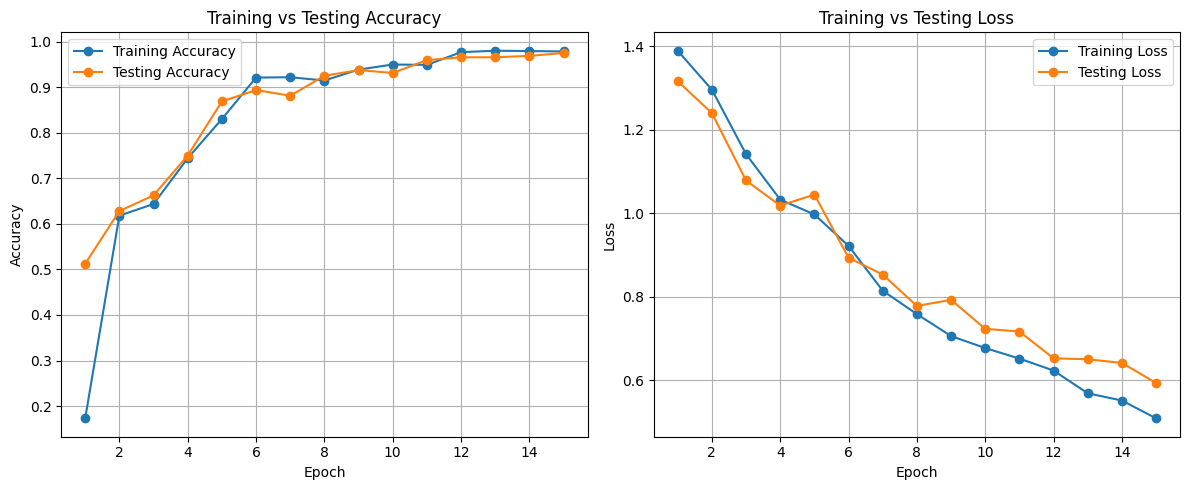

In [8]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define the metrics computation function
def compute_metrics(all_preds, all_labels):
    return {
        "accuracy": accuracy_score(all_labels, all_preds),
        "precision": precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        "recall": recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        "f1": f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    }

# IoU computation (needed for evaluation)
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_g, y1_g, x2_g, y2_g = box2
    xi1 = max(x1, x1_g)
    yi1 = max(y1, y1_g)
    xi2 = min(x2, x2_g)
    yi2 = min(y2, y2_g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_g - x1_g) * (y2_g - y1_g)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

device = torch.device('cuda' if torch.cuda.is_available() else torch.device('cpu'))
model = create_model(num_classes=3).to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop with metrics
num_epochs = 15  # Adjust as needed
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0
    all_train_preds = []
    all_train_labels = []

    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass with targets for training
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())  # Single dictionary in training mode
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        # Compute training predictions in eval mode with torch.no_grad()
        model.eval()
        with torch.no_grad():
            preds = model(images)  # Get predictions without targets in eval mode
            for pred, target in zip(preds, targets):
                pred_labels = pred["labels"].cpu().numpy()
                pred_scores = pred["scores"].cpu().numpy()
                gt_labels = target["labels"].cpu().numpy()
                pred_labels_filtered = pred_labels
                pred_boxes = pred["boxes"].cpu().numpy()
                gt_boxes = target["boxes"].cpu().numpy()

                matched_preds = []
                if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                    for gt_idx, gt_box in enumerate(gt_boxes):
                        best_iou = 0
                        best_pred_idx = -1
                        for pred_idx, pred_box in enumerate(pred_boxes):
                            iou = compute_iou(pred_box, gt_box)
                            if iou > 0.5 and iou > best_iou:
                                best_iou = iou
                                best_pred_idx = pred_idx
                        if best_pred_idx >= 0:
                            matched_preds.append(pred_labels_filtered[best_pred_idx])
                        else:
                            matched_preds.append(0)  # No match, assign plain surface
                else:
                    matched_preds = [0] * len(gt_boxes)  # No predictions, all unmatched

                if len(matched_preds) < len(gt_labels):
                    matched_preds.extend([0] * (len(gt_labels) - len(matched_preds)))
                elif len(matched_preds) > len(gt_labels):
                    matched_preds = matched_preds[:len(gt_labels)]

                all_train_preds.extend(matched_preds)
                all_train_labels.extend(gt_labels)
        model.train()  # Switch back to training mode

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_metrics = compute_metrics(all_train_preds, all_train_labels)
    train_accuracies.append(train_metrics["accuracy"])
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_metrics['accuracy']:.4f}")

    # Evaluation phase
    model.eval()
    epoch_test_loss = 0
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass - returns predictions during evaluation
            preds = model(images)

            # Calculate loss by passing predictions and targets
            # Need to run model again in training mode to get losses
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            epoch_test_loss += losses.item()
            model.eval()

            # Process predictions for metrics
            for pred, target in zip(preds, targets):
                pred_labels = pred["labels"].cpu().numpy()
                gt_labels = target["labels"].cpu().numpy()
                pred_boxes = pred["boxes"].cpu().numpy()
                gt_boxes = target["boxes"].cpu().numpy()

                matched_preds = []
                if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                    for gt_idx, gt_box in enumerate(gt_boxes):
                        best_iou = 0
                        best_pred_idx = -1
                        for pred_idx, pred_box in enumerate(pred_boxes):
                            iou = compute_iou(pred_box, gt_box)
                            if iou > 0.5 and iou > best_iou:
                                best_iou = iou
                                best_pred_idx = pred_idx
                        if best_pred_idx >= 0:
                            matched_preds.append(pred_labels[best_pred_idx])
                        else:
                            matched_preds.append(0)
                else:
                    matched_preds = [0] * len(gt_boxes)

                # Pad or truncate to match gt_labels length
                matched_preds = matched_preds[:len(gt_labels)]
                matched_preds.extend([0] * (len(gt_labels) - len(matched_preds)))

                all_test_preds.extend(matched_preds)
                all_test_labels.extend(gt_labels)

    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_metrics = compute_metrics(all_test_preds, all_test_labels)
    test_accuracies.append(test_metrics["accuracy"])
    print(f"Epoch [{epoch+1}/{num_epochs}] Test Metrics: Acc: {test_metrics['accuracy']:.4f}, Loss: {avg_test_loss:.4f}")

# Save the model
model_path = "/content/drive/MyDrive/final_dataset2/faster_rcnn_lunar_with_attention4.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plotting
plt.figure(figsize=(12, 5))

# Plot 1: Training vs Testing Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.legend()
plt.grid(True)

# Plot 2: Training vs Testing Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Metrics: Acc: 0.9719, Prec: 1.0000, Rec: 0.9719, F1: 0.9857
Classification Report:
              precision    recall  f1-score   support

  background       0.00      0.00      0.00         0
      Crater       1.00      0.97      0.98       259
     Boulder       1.00      0.98      0.99        61

    accuracy                           0.97       320
   macro avg       0.67      0.65      0.66       320
weighted avg       1.00      0.97      0.99       320



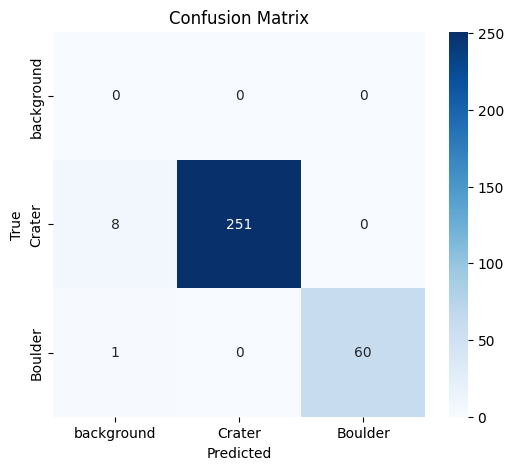

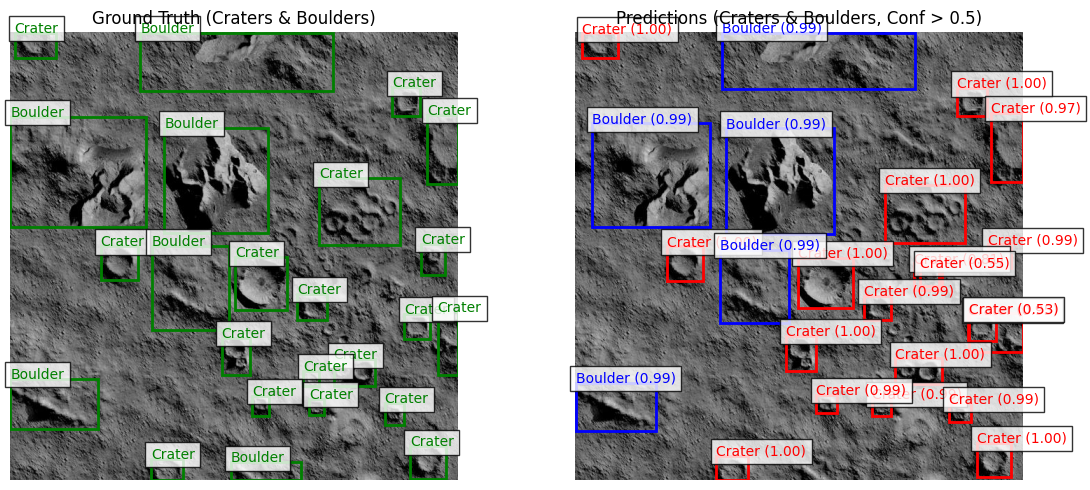

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# IoU computation
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_g, y1_g, x2_g, y2_g = box2
    xi1 = max(x1, x1_g)
    yi1 = max(y1, y1_g)
    xi2 = min(x2, x2_g)
    yi2 = min(y2, y2_g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_g - x1_g) * (y2_g - y1_g)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, targets in test_loader:
        images = list(img.to(device) for img in images)
        preds = model(images)
        for pred, target in zip(preds, targets):
            pred_labels = pred["labels"].cpu().numpy()
            pred_scores = pred["scores"].cpu().numpy()
            gt_labels = target["labels"].cpu().numpy()
            # Include all predictions for metrics (no threshold here)
            pred_labels_filtered = pred_labels
            pred_boxes = pred["boxes"].cpu().numpy()
            gt_boxes = target["boxes"].cpu().numpy()

            matched_preds = []
            if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                for gt_idx, gt_box in enumerate(gt_boxes):
                    best_iou = 0
                    best_pred_idx = -1
                    for pred_idx, pred_box in enumerate(pred_boxes):
                        iou = compute_iou(pred_box, gt_box)
                        if iou > 0.5 and iou > best_iou:
                            best_iou = iou
                            best_pred_idx = pred_idx
                    if best_pred_idx >= 0:
                        matched_preds.append(pred_labels_filtered[best_pred_idx])
                    else:
                        matched_preds.append(0)  # No match, assign plain surface
            else:
                matched_preds = [0] * len(gt_boxes)  # No predictions, all unmatched

            if len(matched_preds) < len(gt_labels):
                matched_preds.extend([0] * (len(gt_labels) - len(matched_preds)))
            elif len(matched_preds) > len(gt_labels):
                matched_preds = matched_preds[:len(gt_labels)]

            all_preds.extend(matched_preds)
            all_labels.extend(gt_labels)

# Compute and display metrics
metrics = {
    "accuracy": accuracy_score(all_labels, all_preds),
    "precision": precision_score(all_labels, all_preds, average='weighted', zero_division=0),
    "recall": recall_score(all_labels, all_preds, average='weighted', zero_division=0),
    "f1": f1_score(all_labels, all_preds, average='weighted', zero_division=0)
}
print(f"Metrics: Acc: {metrics['accuracy']:.4f}, Prec: {metrics['precision']:.4f}, Rec: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["background", "Crater", "Boulder"], labels=[0, 1, 2], zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["background", "Crater", "Boulder"],
            yticklabels=["background", "Crater", "Boulder"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Visualize sample prediction (show only craters and boulders with confidence > 0.5)
def plot_prediction(images, preds, targets, idx=0):
    img = images[idx].cpu().permute(1, 2, 0).numpy()
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    for box, label in zip(targets[idx]["boxes"], targets[idx]["labels"]):
        box = box.cpu().numpy()
        if label in [1, 2]:  # Only visualize craters and boulders
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                              fill=False, edgecolor="green", linewidth=2))
            plt.text(box[0], box[1], f"{'Crater' if label == 1 else 'Boulder'}",
                     color="green", bbox=dict(facecolor="white", alpha=0.8))
    plt.title("Ground Truth (Craters & Boulders)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    for box, label, score in zip(preds[idx]["boxes"], preds[idx]["labels"], preds[idx]["scores"]):
        box = box.cpu().numpy()
        if label in [1, 2] and score > 0.5:  # Only visualize craters and boulders with confidence > 0.5
            color = "red" if label == 1 else "blue"
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                              fill=False, edgecolor=color, linewidth=2))
            plt.text(box[0], box[1], f"{'Crater' if label == 1 else 'Boulder'} ({score:.2f})",
                     color=color, bbox=dict(facecolor="white", alpha=0.8))
    plt.title("Predictions (Craters & Boulders, Conf > 0.5)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

images, targets = next(iter(test_loader))
with torch.no_grad():
    preds = model(list(img.to(device) for img in images))
plot_prediction(images, preds, targets, idx=0)